In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torch import optim
from tqdm.auto import tqdm
import math
torch.manual_seed(55)

# read in data

In [2]:
path = "W://Study Material/Jupyter Notebook/Datasets/CIFAR-10/cifar-10-batches-py"
def unpickle(file):
    import pickle
    with open(file, "rb") as fo:
        dict = pickle.load(fo,encoding="bytes")
    return dict

In [3]:
training_batch = np.empty((4),dtype=object)
val_batch = np.empty((1),dtype=object)
test_batch = np.empty((1),dtype=object)
training_batch.shape

(4,)

In [4]:
training_batch[0] = unpickle(path+"/data_batch_1")
training_batch[1] = unpickle(path+"/data_batch_2")
training_batch[2] = unpickle(path+"/data_batch_3")
training_batch[3] = unpickle(path+"/data_batch_4")
val_batch[0] = unpickle(path+"/data_batch_5")
test_batch[0] = unpickle(path+"/test_batch")
meta_data = unpickle(path+"/batches.meta")

In [5]:
training_batch[0].keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [6]:
np.array(training_batch[0][b'labels']).shape

(10000,)

In [7]:
training_batch[0][b'data'].shape

(10000, 3072)

In [8]:
meta_data[b'label_names']

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

# define custom data loader

In [9]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self,batch,b_type,transform):
        self.transform = transform
        if b_type == "train":
            self.data = np.concatenate((batch[0][b'data'],batch[1][b'data'],
                                        batch[2][b'data'],batch[3][b'data']),axis=0)
            #print(b_type, " data shape: ",self.data.shape)
            self.label = np.concatenate((batch[0][b'labels'],batch[1][b'labels'],
                                        batch[2][b'labels'],batch[3][b'labels']))
            #print(b_type, " label shape: ",len(self.label))
        else:
            self.data = batch[0][b'data']
            #print(b_type, " data shape: ",self.data.shape)
            self.label = batch[0][b'labels']
            #print(b_type, " label shape: ", len(self.label))
    
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self,index):
        label = self.label[index]
        image_data = self.data[index]
        # convert (3072,) array to (3,32,32)
        image_r = image_data[:1024].reshape(32,32)
        image_g = image_data[1024:2048].reshape(32,32)
        image_b = image_data[2048:].reshape(32,32)
        image = np.array([image_r,image_g,image_b])
        image = np.transpose(image,(1,2,0)) # change the batch dimension to the last dimension
        #image = torch.tensor(image,dtype=torch.float)
        if self.transform is not None:
            image = self.transform(image)
        #print(image.shape)
        return image, label
    

In [10]:
x = np.ones((1,2,3))
np.transpose(x,(2,0,1)).shape

(3, 1, 2)

### transformation

In [11]:
# define data augmentation
data_transformers = {"train": transforms.Compose([transforms.ToPILImage(),
                                     transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomRotation(30),
                                     transforms.ToTensor()]),
            "test":transforms.Compose([transforms.ToPILImage(),
                                       transforms.Resize(224),
                                       transforms.ToTensor()])}

### datasets

In [12]:
# defining datasets
train_data = CustomDataset(training_batch,"train",transform=data_transformers["train"])
val_data = CustomDataset(val_batch,"validation",transform=data_transformers["test"])
test_data = CustomDataset(test_batch,"test",transform=data_transformers["test"])

In [13]:
# make sure the shape of the image extracted is okay
print(train_data[0][0].shape)
#print(train_data[0][1])

torch.Size([3, 224, 224])


### dataloader

In [14]:
train_dataloader = DataLoader(train_data,batch_size=128,shuffle=True)
val_dataloader = DataLoader(val_data,batch_size=128,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=128,shuffle=False)

# training and validation routine

In [19]:
def train(model,trainloader,valloader,epochs,print_frequency,loss_fn,optimizer,device,run,part):
    training_steps = epochs * (len(trainloader))
    progress_bar = tqdm(range(training_steps))
    ep = epochs
    print_every = math.floor(training_steps/print_frequency)
    steps = 0
    model.to(device)
    model.train()
    total = 0
    correct = 0
    best_val = 10000
    
    current_loss = 0
    
    for e in np.arange(ep):
        for batch,(images,labels) in enumerate(trainloader):
            steps += 1
            images, labels = images.to(device), labels.to(device)
            # convert images to float because weights are floats
            images = images.float()
            labels = labels.type(torch.long) # need to be int
            
            # calculate loss and backpropogate
            optimizer.zero_grad()
            outputs = model(images)
            _,predictions = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predictions == labels).sum().item()
            loss = loss_fn(outputs,labels)
            loss.backward()
            optimizer.step()
            
            current_loss += loss.item()
            progress_bar.update(1)
            
            if steps % print_every == 0:
                print('EPOCHS : {}/{}'.format(e+1,epochs),
                      'Loss : {:.6f}'.format(current_loss/print_every)) 
                print('The training accuracy is {:.2f}%'.format(correct/total*100))
                current_loss = 0
                val_loss = validate(model,valloader,loss_fn, device)
                if val_loss < best_val:
                    torch.save(model.state_dict(),"Weights/part-{}-run-{}-Best.pth".format(str(part),
                                                                                           str(run)))
    torch.save(model.state_dict(),"Weights/part-{}-run-{}-Last.pth".format(str(part),
                                                                           str(run)))

In [25]:
# extracting top predictions from original alex net
def predict(model, valloader, loss_fn, device):
    model.eval()
    predictions_count = np.zeros(1000)
    predictionss = []
    true_labels = []
    true_labels_count = np.zeros(10)
    with torch.no_grad():
        for batch, (images,labels) in enumerate(valloader):
            images, labels = images.to(device), labels.to(device)
            # convert images to float because weights are floats
            images = images.float()
            labels = labels.type(torch.long) # need to be int
            outputs = model(images)
            _, predictions = torch.max(outputs.data,1)
            for i in predictions:
                predictions_count[i] += 1
            for i in labels:
                true_labels_count[i] += 1
            predictionss.extend(predictions.to("cpu"))
            true_labels.extend(labels.to("cpu"))
    return true_labels, predictionss, true_labels_count, predictions_count

In [23]:
#old
def validate(model, valloader, loss_fn, device):
    total = 0
    correct = 0
    val_loss = 0
    model.eval()
    steps = 0
    with torch.no_grad():
        for batch, (images,labels) in enumerate(valloader):
            images, labels = images.to(device), labels.to(device)
            # convert images to float because weights are floats
            images = images.float()
            labels = labels.type(torch.long) # need to be int
            steps += 1
            outputs = model(images)
            _, predictions = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (labels == predictions).sum().item()
            loss = loss_fn(outputs,labels)
            val_loss += loss.item()
    val_loss /= steps
    accuracy = correct / total * 100
    print("The validation loss is %.4f" % (val_loss))
    print('The valudation accuracy is {:.2f}%\n'.format(accuracy))
    return val_loss

# Part b)

In [18]:
AlexNet = models.alexnet(pretrained=False)
AlexNet.load_state_dict(torch.load("W://Study Material/Jupyter Notebook/Pretrained_Weights/alexnet-owt-7be5be79.pth"))
AlexNet.cuda()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [26]:
# get predictions and true labels
true_labels, predictionss, true_labels_count, predictions_count = predict(AlexNet, test_dataloader, "loss", "cuda")

In [28]:
# calculate top predictions
top_predictions_idx =  predictions_count.argsort()[-10:][::-1]
top_predictions_count = predictions_count[top_predictions_idx]
print(top_predictions_idx)
print(top_predictions_count)

[901 680  80 351 190 556 111 653 813 712]
[3023. 2226.  695.  501.  410.  343.  299.  297.  173.  172.]


In [32]:
# read in the image net labels
with open('imagenet_classes.txt') as f:
    imgnet_labels = [line.strip() for line in f.readlines()]

In [33]:
imgnet_labels[:10]

['0, tench',
 '1, goldfish',
 '2, great_white_shark',
 '3, tiger_shark',
 '4, hammerhead',
 '5, electric_ray',
 '6, stingray',
 '7, cock',
 '8, hen',
 '9, ostrich']

In [34]:
top_classes = []
for i in top_predictions_idx:
    top_classes.append(imgnet_labels[i])

top_classes

['901, whiskey_jug',
 '680, nipple',
 '80, black_grouse',
 '351, hartebeest',
 '190, Sealyham_terrier',
 '556, fire_screen',
 '111, nematode',
 '653, milk_can',
 '813, spatula',
 '712, Petri_dish']

In [38]:
predictions_np = np.array(predictionss)
truelabel_np = np.array(true_labels)

10000

## confusion matrix

In [47]:
# Build confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

predict_class = [imgnet_labels[i] for i in predictions_np]  

indices = [] 

for idx,each in enumerate(predict_class):
    if each in top_classes:
        indices.append(idx)

print(len(indices))

predict_class = [top_classes.index(predict_class[i]) for i in indices] 

true_class = [truelabel_np[i] for i in indices] 

Matrix= confusion_matrix(true_class, predict_class)

8139


In [71]:
# extract the names for the top predicted classes
top_classes[0].split()[1]
top_classes_names = [top_classes[i].split()[1] for i in np.arange(len(top_classes))]

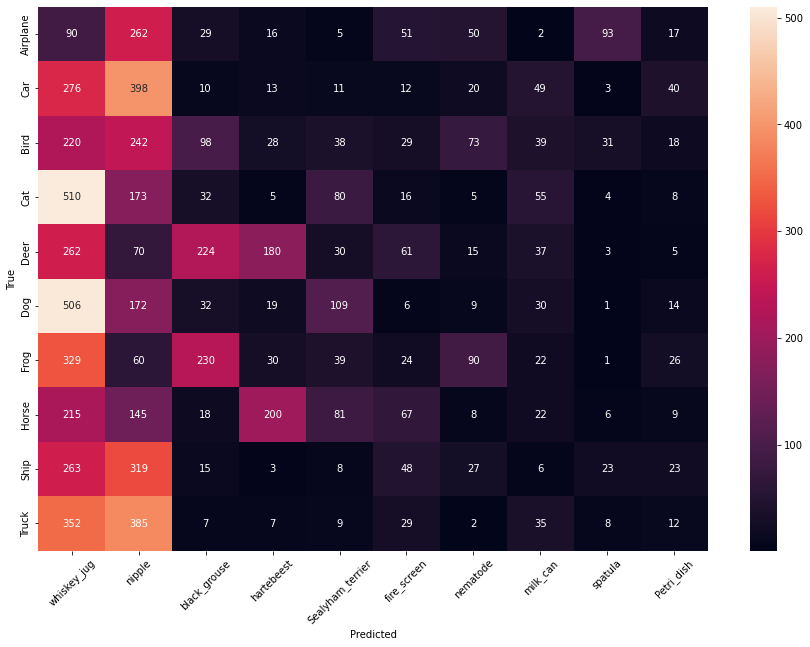

In [72]:
fig = plt.figure(figsize=(15,10))
ax= plt.subplot()
sn.heatmap(Matrix, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Predicted')
plt.xticks(rotation=45)
ax.xaxis.set_ticklabels(top_classes_names)
ax.xaxis.tick_bottom()
ax.set_ylabel('True')
cifar_classes = ('Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')
ax.yaxis.set_ticklabels(cifar_classes)

plt.savefig('cm.png')
plt.show()


# Part c)

In [59]:
AlexNet2 = models.alexnet(pretrained=False)
AlexNet2.load_state_dict(torch.load("W://Study Material/Jupyter Notebook/Pretrained_Weights/alexnet-owt-7be5be79.pth"))
AlexNet2.cuda()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [60]:
AlexNet2.classifier = nn.Sequential(
    nn.Dropout(0.5,False),
    nn.Linear(9216,4096,True),
    nn.Linear(4096,10,True) # will train this layer
)
print(AlexNet2)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [65]:
# freeze all layers except for the last one so that we only train the last layer (classifier)
for name, param in AlexNet2.named_parameters():
    if name != "classifier.2.weight" and name != "classifier.2.bias":
        param.requires_grad = False
    print(name)
    print(param.requires_grad)

features.0.weight
False
features.0.bias
False
features.3.weight
False
features.3.bias
False
features.6.weight
False
features.6.bias
False
features.8.weight
False
features.8.bias
False
features.10.weight
False
features.10.bias
False
classifier.1.weight
False
classifier.1.bias
False
classifier.2.weight
True
classifier.2.bias
True


In [66]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(AlexNet2.parameters(),lr=1e-4)

In [67]:
train(AlexNet2,train_dataloader,val_dataloader,10,20,loss_fn,optimizer,"cuda",1,"c")

  0%|          | 0/3130 [00:00<?, ?it/s]

EPOCHS : 1/10 Loss : 2.198151
The training accuracy is 19.57%
The validation loss is 2.0677
The valudation accuracy is 30.33%

EPOCHS : 1/10 Loss : 2.002858
The training accuracy is 26.24%
The validation loss is 1.9146
The valudation accuracy is 30.71%

EPOCHS : 2/10 Loss : 1.904387
The training accuracy is 29.28%
The validation loss is 1.7687
The valudation accuracy is 42.49%

EPOCHS : 2/10 Loss : 1.831361
The training accuracy is 31.36%
The validation loss is 1.6840
The valudation accuracy is 41.31%

EPOCHS : 3/10 Loss : 1.779761
The training accuracy is 32.89%
The validation loss is 1.6018
The valudation accuracy is 45.18%

EPOCHS : 3/10 Loss : 1.756415
The training accuracy is 33.99%
The validation loss is 1.5451
The valudation accuracy is 48.27%

EPOCHS : 4/10 Loss : 1.729908
The training accuracy is 34.91%
The validation loss is 1.4876
The valudation accuracy is 51.47%

EPOCHS : 4/10 Loss : 1.691144
The training accuracy is 35.75%
The validation loss is 1.4576
The valudation accu

In [30]:
optimizer = optim.Adam(AlexNet2.parameters(),lr=1e-6)
train(AlexNet2,train_dataloader,val_dataloader,10,20,loss_fn,optimizer,"cuda",2,"c")

  0%|          | 0/3130 [00:00<?, ?it/s]

EPOCHS : 1/10 Loss : 0.983893
The training accuracy is 65.21%
The validation loss is 0.4936
The valudation accuracy is 83.12%

EPOCHS : 1/10 Loss : 0.904120
The training accuracy is 66.81%
The validation loss is 0.4828
The valudation accuracy is 83.32%

EPOCHS : 2/10 Loss : 0.906161
The training accuracy is 67.25%
The validation loss is 0.4769
The valudation accuracy is 83.34%

EPOCHS : 2/10 Loss : 0.900338
The training accuracy is 67.54%
The validation loss is 0.4763
The valudation accuracy is 83.48%

EPOCHS : 3/10 Loss : 0.921114
The training accuracy is 67.56%
The validation loss is 0.4737
The valudation accuracy is 83.46%

EPOCHS : 3/10 Loss : 0.895418
The training accuracy is 67.72%
The validation loss is 0.4758
The valudation accuracy is 83.38%

EPOCHS : 4/10 Loss : 0.905156
The training accuracy is 67.83%
The validation loss is 0.4768
The valudation accuracy is 83.53%

EPOCHS : 4/10 Loss : 0.887147
The training accuracy is 67.99%
The validation loss is 0.4795
The valudation accu

In [31]:
optimizer = optim.Adam(AlexNet2.parameters(),lr=1e-8)
#AlexNet.load_state_dict(torch.load("Weights/part-c-run-2-Best.pth"))
train(AlexNet2,train_dataloader,val_dataloader,10,20,loss_fn,optimizer,"cuda",3,"c")

  0%|          | 0/3130 [00:00<?, ?it/s]

EPOCHS : 1/10 Loss : 0.960729
The training accuracy is 65.96%
The validation loss is 0.4728
The valudation accuracy is 83.51%

EPOCHS : 1/10 Loss : 0.884539
The training accuracy is 67.56%
The validation loss is 0.4713
The valudation accuracy is 83.52%

EPOCHS : 2/10 Loss : 0.894978
The training accuracy is 67.94%
The validation loss is 0.4709
The valudation accuracy is 83.56%

EPOCHS : 2/10 Loss : 0.900989
The training accuracy is 68.03%
The validation loss is 0.4811
The valudation accuracy is 83.58%

EPOCHS : 3/10 Loss : 0.895619
The training accuracy is 68.20%
The validation loss is 0.4710
The valudation accuracy is 83.62%

EPOCHS : 3/10 Loss : 0.904552
The training accuracy is 68.23%
The validation loss is 0.4682
The valudation accuracy is 83.59%

EPOCHS : 4/10 Loss : 0.898023
The training accuracy is 68.27%
The validation loss is 0.4718
The valudation accuracy is 83.64%

EPOCHS : 4/10 Loss : 0.896598
The training accuracy is 68.29%
The validation loss is 0.4702
The valudation accu

In [48]:
AlexNet2.load_state_dict(torch.load("Weights/part-c-run-3-Best.pth"))

<All keys matched successfully>

In [51]:
AlexNet2.cuda()
val_loss = validate(AlexNet2, test_dataloader, loss_fn, "cuda")

The validation loss is 0.4810
The valudation accuracy is 83.54%



# Part d)

In [32]:
AlexNet3 = models.alexnet(pretrained=False)
AlexNet3.load_state_dict(torch.load("W://Study Material/Jupyter Notebook/Pretrained_Weights/alexnet-owt-7be5be79.pth"))
AlexNet3.cuda()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [34]:
AlexNet3.classifier[6] = nn.Linear(4096,10,True)
print(AlexNet3)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [35]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(AlexNet3.parameters(),lr=1e-5)

In [36]:
train(AlexNet3,train_dataloader,val_dataloader,10,20,loss_fn,optimizer,"cuda",1,"d")

  0%|          | 0/3130 [00:00<?, ?it/s]

EPOCHS : 1/10 Loss : 1.850561
The training accuracy is 32.47%
The validation loss is 1.2623
The valudation accuracy is 55.76%

EPOCHS : 1/10 Loss : 1.405315
The training accuracy is 40.75%
The validation loss is 0.9747
The valudation accuracy is 65.92%

EPOCHS : 2/10 Loss : 1.257076
The training accuracy is 45.55%
The validation loss is 0.8586
The valudation accuracy is 69.45%

EPOCHS : 2/10 Loss : 1.177570
The training accuracy is 48.66%
The validation loss is 0.7658
The valudation accuracy is 73.17%

EPOCHS : 3/10 Loss : 1.127938
The training accuracy is 50.88%
The validation loss is 0.6838
The valudation accuracy is 76.32%

EPOCHS : 3/10 Loss : 1.089887
The training accuracy is 52.55%
The validation loss is 0.6361
The valudation accuracy is 78.05%

EPOCHS : 4/10 Loss : 1.061739
The training accuracy is 53.94%
The validation loss is 0.6482
The valudation accuracy is 77.48%

EPOCHS : 4/10 Loss : 1.048316
The training accuracy is 55.06%
The validation loss is 0.5840
The valudation accu

In [37]:
optimizer = optim.Adam(AlexNet3.parameters(),lr=1e-6)
train(AlexNet3,train_dataloader,val_dataloader,10,20,loss_fn,optimizer,"cuda",2,"d")

  0%|          | 0/3130 [00:00<?, ?it/s]

EPOCHS : 1/10 Loss : 1.000398
The training accuracy is 64.65%
The validation loss is 0.4515
The valudation accuracy is 84.18%

EPOCHS : 1/10 Loss : 0.840051
The training accuracy is 67.60%
The validation loss is 0.4455
The valudation accuracy is 84.52%

EPOCHS : 2/10 Loss : 0.841163
The training accuracy is 68.52%
The validation loss is 0.4427
The valudation accuracy is 84.39%

EPOCHS : 2/10 Loss : 0.834193
The training accuracy is 69.07%
The validation loss is 0.4453
The valudation accuracy is 84.51%

EPOCHS : 3/10 Loss : 0.842139
The training accuracy is 69.33%
The validation loss is 0.4452
The valudation accuracy is 84.52%

EPOCHS : 3/10 Loss : 0.832247
The training accuracy is 69.59%
The validation loss is 0.4508
The valudation accuracy is 84.45%

EPOCHS : 4/10 Loss : 0.829938
The training accuracy is 69.76%
The validation loss is 0.4495
The valudation accuracy is 84.32%

EPOCHS : 4/10 Loss : 0.840508
The training accuracy is 69.87%
The validation loss is 0.4373
The valudation accu

In [38]:
optimizer = optim.Adam(AlexNet3.parameters(),lr=1e-8)
#AlexNet.load_state_dict(torch.load("Weights/part-d-run-2-Best.pth"))
train(AlexNet3,train_dataloader,val_dataloader,10,20,loss_fn,optimizer,"cuda",3,"d")

  0%|          | 0/3130 [00:00<?, ?it/s]

EPOCHS : 1/10 Loss : 0.991773
The training accuracy is 64.99%
The validation loss is 0.4360
The valudation accuracy is 84.82%

EPOCHS : 1/10 Loss : 0.805074
The training accuracy is 68.39%
The validation loss is 0.4337
The valudation accuracy is 84.83%

EPOCHS : 2/10 Loss : 0.811057
The training accuracy is 69.44%
The validation loss is 0.4410
The valudation accuracy is 84.85%

EPOCHS : 2/10 Loss : 0.822433
The training accuracy is 69.90%
The validation loss is 0.4325
The valudation accuracy is 84.87%

EPOCHS : 3/10 Loss : 0.820671
The training accuracy is 70.17%
The validation loss is 0.4350
The valudation accuracy is 84.86%

EPOCHS : 3/10 Loss : 0.810344
The training accuracy is 70.41%
The validation loss is 0.4347
The valudation accuracy is 84.86%

EPOCHS : 4/10 Loss : 0.813434
The training accuracy is 70.58%
The validation loss is 0.4321
The valudation accuracy is 84.92%

EPOCHS : 4/10 Loss : 0.816192
The training accuracy is 70.63%
The validation loss is 0.4329
The valudation accu